# High Value Customers Identification (Insiders)

## Planejamento da solução (IoT)

### Input

1. Problema de negócio
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização
    
2. Conjunto de dados
    - Vendas de um e-commerce online, durante o período do ano.
    

### Output

1. A identificação das pessoas que farão parte do programa de insiders
    - Lista: Client_id |  Insiders
    
2. Relatório com as respostas das perguntas de negócio
    - Quem são as pessoas elegíveis para participação do programa de insiders?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes?
    - Qual a porcentagem de contribuição do faturamento, vinda do insiders?
    - Qual a expectativa de faturamento desse grupo pata os próximos meses?
    - Quais as condições para uma pessoa ser elegível ao insiders?
    - Quais as condições para uma pessoa ser removida do insiders?
    - Qual a garantia que o programa insiders é melhor que o restante da base?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?
    

### Task

1. Quem são as pessoas elegíveis para participação do programa de insiders?
    - O que é ser elegível? o que são clientes de maior "valor"?
    - Faturamento
        - Alto ticket médio
        - Alto LTV (soma de tudo que gastou)
        - Baixa recência
        - Alto basket size (tamanho da cesta de compra)
        - Baixa probabilidade de churn (pessoa que parou de comprar)
    - Custo
        - Baixa taxa de devolução
        
    - Experiência de compra
        - Média alta de avaliação
        
        
2. Quantos clientes farão parte do grupo?
    - Número total de clientes
    - % do grupo de insiders
    
    
3. Quais as principais características desses clientes?
    - Escrever características do cliente
        - Idade
        - Localização
        
    - Escrever características do consumo
        - Features da clusterização
        
        
4. Qual a porcentagem de contribuição do faturamento, vinda do insiders?
    - Calcula o faturamento total do ano
    - Faturamento do grupo insiders
    
    
5. Qual a expectativa de faturamento desse grupo pata os próximos meses?
    - LTV do grupo insiders
    - Análise de cohort (análise onde marca a pessoa no tempo)
    
    
6. Quais as condições para uma pessoa ser elegível ao insiders?
    - Definir a peridiocidade (1 mes, 3 meses)
    - A pessoa precisa ser similar ou parecida com uma pessoa do grupo
    
    
7. Quais as condições para uma pessoa ser removida do insiders?
    - Definir peridiocidade
    - pessoa precisa ser desimilar ou não-parecido com uma pessoa do grupo
    
    
8. Qual a garantia que o programa insiders é melhor que o restante da base?
    - Teste A/B
    - Teste A/B Bayesiano
    - teste de hipótese
    
    
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
     - Desconto
     - Preferência de compra
     - frete
     - visita a empresa

# 0.0. Imports

In [1]:
import inflection
import re

import pandas  as pd
import numpy   as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.cluster       import KMeans
from sklearn.metrics       import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from yellowbrick.cluster   import KElbowVisualizer, SilhouetteVisualizer

import plotly.express as px

import umap.umap_ as umap

In [2]:
def numeric_statistics( df ):
    
    dic = {
        "type": df.dtypes.values,
        "Unique_Values": df.nunique().values,
        "Mean": df.mean(),
        "Median": df.median(),
        "Std": df.std(),
        "Min": df.min(),
        "Max": df.max(),
        "Range": df.max() - df.min(),
        "Skew": df.skew(),
        "Kurtosis": df.kurtosis()
    }
    
    return pd.DataFrame( dic, index=df.columns )


# 1.0. Descrioção dos dados

In [58]:
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding='unicode_escape')

df_raw = df_raw.drop(columns=['Unnamed: 8'])

In [59]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1 Rename Columns

In [60]:
# rename columns
old_columns = df_raw.columns

func = lambda x: inflection.underscore(x)

new_columns = list(map(func, old_columns))
df_raw.columns = new_columns

## 1.2 Data Dimensions

In [61]:
df_raw.shape

(541909, 8)

## 1.3 Data Types

In [62]:
df_raw.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check Na

In [63]:
df_raw.isnull().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 FillNa

In [9]:
df1 = df_raw.dropna(subset=['description','customer_id'])
print('Removed data: {:.2f}%'.format(100* (1 - (df1.shape[0]/df_raw.shape[0]))))

Removed data: 24.93%


In [10]:
df1.shape

(406829, 8)

## 1.6 Change Dtypes

In [11]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [12]:
df1.head(2)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom


In [13]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )
df1.head()

/home/marcos/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/marcos/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


## 1.7 Descriptive Statistics

In [14]:
num_atributes = df1.select_dtypes(include=['int64','float64'])
cat_atributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numeric atributes 

In [15]:
numeric_statistics(num_atributes)

,type,Unique_Values,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
quantity,int64,436,12.061303,5.00,248.693370,-80995.0,80995.0,161990.0,0.182663,94317.563673
unit_price,float64,620,3.460471,1.95,69.315162,0.0,38970.0,38970.0,452.219019,246924.542988
customer_id,int64,4372,15287.690570,15152.00,1713.600303,12346.0,18287.0,5941.0,0.029835,-1.179982


1. 'quantity' negativa ( pode ser devolução )
2. Preço unitário igual a zero ( min )

### 1.7.1 Categorical Atributes

In [16]:
cat_atributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [17]:
# invoice_no
index = cat_atributes['invoice_no'].apply( lambda x: bool(re.search('[^0-9]+', x)))
cat_atributes.loc[index, 'invoice_no'].unique().shape

(3654,)

In [18]:
# stock code
index = cat_atributes['stock_code'].apply( lambda x: bool(re.search('[^0-9]+', x)))
print(cat_atributes.loc[index, 'stock_code'].shape)#.unique().shape

# stock code - posicoes que contenham somente strings
index = cat_atributes['stock_code'].apply( lambda x: bool(re.search('^[a-zA-Z]+$', x)))
cat_atributes.loc[index, 'stock_code'].unique()

(35809,)


array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

## Invoice No

In [19]:
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool(re.search('[^0-9]+',x))), :]
df_letter_invoices.shape

(8905, 8)

In [20]:
# em todos os invoices que tem pelo menos uma letra tem o quantity como negativo
df_letter_invoices[df_letter_invoices['quantity'] < 0].shape

(8905, 8)

## Stock Code

In [21]:
df1.loc[df1['stock_code'].apply( lambda x: bool(re.search('^[a-zA-z]+$',x))), 'stock_code'].unique()

# 1.0. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

## Description

In [22]:
df1.head()

# 1.0. deletar

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


## Country

In [23]:
df1[['country']].value_counts(normalize=True)

country             
United Kingdom          0.889509
Germany                 0.023339
France                  0.020871
EIRE                    0.018398
Spain                   0.006226
Netherlands             0.005828
Belgium                 0.005086
Switzerland             0.004614
Portugal                0.003638
Australia               0.003095
Norway                  0.002669
Italy                   0.001974
Channel Islands         0.001863
Finland                 0.001708
Cyprus                  0.001529
Sweden                  0.001136
Austria                 0.000986
Denmark                 0.000956
Japan                   0.000880
Poland                  0.000838
USA                     0.000715
Israel                  0.000615
Unspecified             0.000600
Singapore               0.000563
Iceland                 0.000447
Canada                  0.000371
Greece                  0.000359
Malta                   0.000312
United Arab Emirates    0.000167
European Community    

In [24]:
df1[['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False)

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


# 2.0. Filtragem de variáveis

In [25]:
df2 = df1.copy()

In [26]:
 # === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'] )]

# description
df2 = df2.drop( columns='description', axis=1 )

# map 
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchases = df2.loc[df2['quantity'] >= 0, :]

# 3.0. Feature Engineering

In [27]:
df3 = df2.copy()

In [28]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

In [29]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

/home/marcos/miniconda3/envs/clustering/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [30]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:,['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

/home/marcos/miniconda3/envs/clustering/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


customer_id       0
gross_revenue    27
dtype: int64

In [31]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

In [32]:
# Frequency
df_freq = df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index()
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
dtype: int64

In [33]:
# Avg Ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

In [34]:
df_ref.head() 

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5391.21,372.0,34.0,18.152222
1,13047,3232.59,56.0,9.0,18.904035
2,12583,6705.38,2.0,15.0,28.902500
3,13748,948.25,95.0,5.0,33.866071
4,15100,876.00,333.0,3.0,292.000000



## RFM

In [35]:
# # gross revenue (faturamento) quantity * price
# df3['gross_revenue'] = df3['quantity'] * df3['unit_price']

# # monetary
# df_monetary = df3[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
# df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# # recency
# df_recency = df3[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
# df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
# df_recency = df_recency[['customer_id','recency_days']].copy()

# df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

# # frequency
# df_freq = df3[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
# df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

# # Avg Ticket
# df_avg_ticket = df3[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})

# df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

# 4.0. EDA

In [36]:
df4 = df_ref.dropna().copy()

In [37]:
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
dtype: int64

# 5.0. Data Preparation

In [38]:
df5 = df4.copy()

In [39]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5391.21,372.0,34.0,18.152222
1,13047,3232.59,56.0,9.0,18.904035
2,12583,6705.38,2.0,15.0,28.902500
3,13748,948.25,95.0,5.0,33.866071
4,15100,876.00,333.0,3.0,292.000000


In [40]:
ss = MinMaxScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])

# 6.0. Feature Selection

In [41]:
df6 = df5.copy()

# 7.0. Hyperparameter Fine-Tunning

In [42]:
df7 = df6.drop(columns=['customer_id'])
x = df7.copy()

In [43]:
df7.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,0.019301,0.997319,0.160976,0.000208
1,0.011567,0.150134,0.039024,0.000218
2,0.024009,0.005362,0.068293,0.000347
3,0.003384,0.254692,0.019512,0.000412
4,0.003125,0.892761,0.009756,0.003756


In [44]:
clusters = list(range(2,8))

## 7.1 Within-Cluster Sum of Square (WSS)

Text(0.5, 1.0, 'WSS x K')

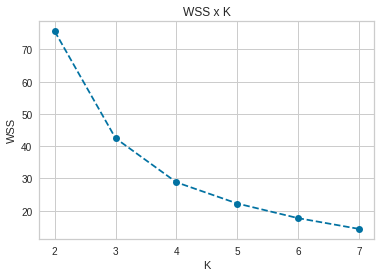

In [45]:
wss = []
for k in clusters:
    
    # model definition
    model = KMeans(
        init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    # model fit
    model.fit(x)
    
    # validation
    wss.append(model.inertia_)
    
plt.plot(
    clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('WSS')
plt.title('WSS x K')

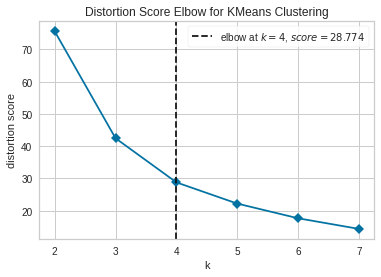

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [46]:
model_02 = KElbowVisualizer(KMeans(), k=clusters, timings=False)
model_02.fit(x)
model_02.show()

## 7.2 Sillhoutte Score

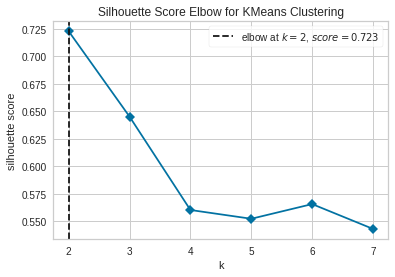

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [47]:
model_02 = KElbowVisualizer(KMeans(), k=clusters, timings=False, metric='silhouette')
model_02.fit(x)
model_02.show()

## 7.3. Sillhouette Analysis

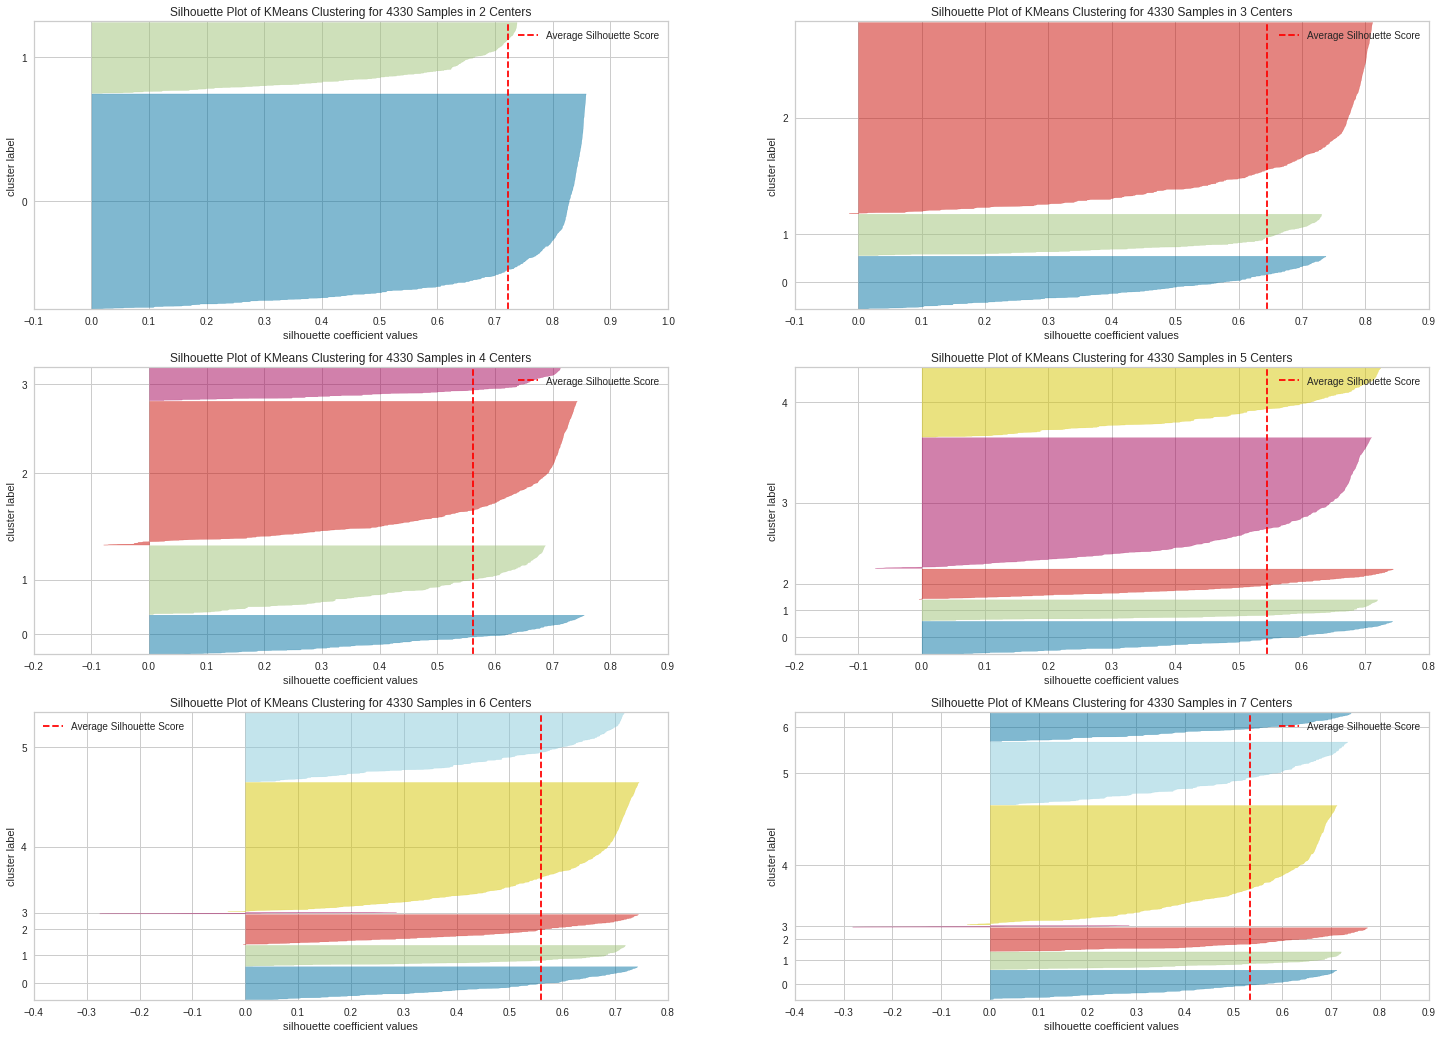

In [48]:
fig, ax = plt.subplots(3,2, figsize=(25,18))

for k in clusters:
    km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k,2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(x)
    visualizer.finalize()

# 8.0. Model Training

## 8.1. K-Means

In [49]:
k = 6

# model definition
kmeans = KMeans(
    n_clusters=k, init='random', n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(x)

# clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [50]:
## WSS ( Within-Cluster sum of square )
print(f'WSS Value: {kmeans.inertia_} \n')

## SS ( Silhouette Score )
print(f'Silhouette Score: {silhouette_score(x, labels)}')

WSS Value: 17.6775426073793 

Silhouette Score: 0.5590636719986625


# 9.0. Cluster Analysis

In [51]:
df9 = df6.copy()

df9['cluster'] = labels.astype('str')
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,0.019301,0.997319,0.160976,0.000208,1
1,13047,0.011567,0.150134,0.039024,0.000218,5
2,12583,0.024009,0.005362,0.068293,0.000347,4
3,13748,0.003384,0.254692,0.019512,0.000412,5
4,15100,0.003125,0.892761,0.009756,0.003756,1


## 9.1. Cluster Inspection 

/home/marcos/miniconda3/envs/clustering/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


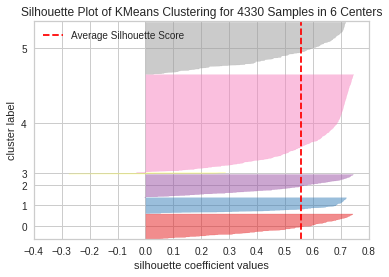

In [52]:
visualizer = SilhouetteVisualizer(kmeans, color='yellowbrick')
visualizer.fit(x)
visualizer.finalize()

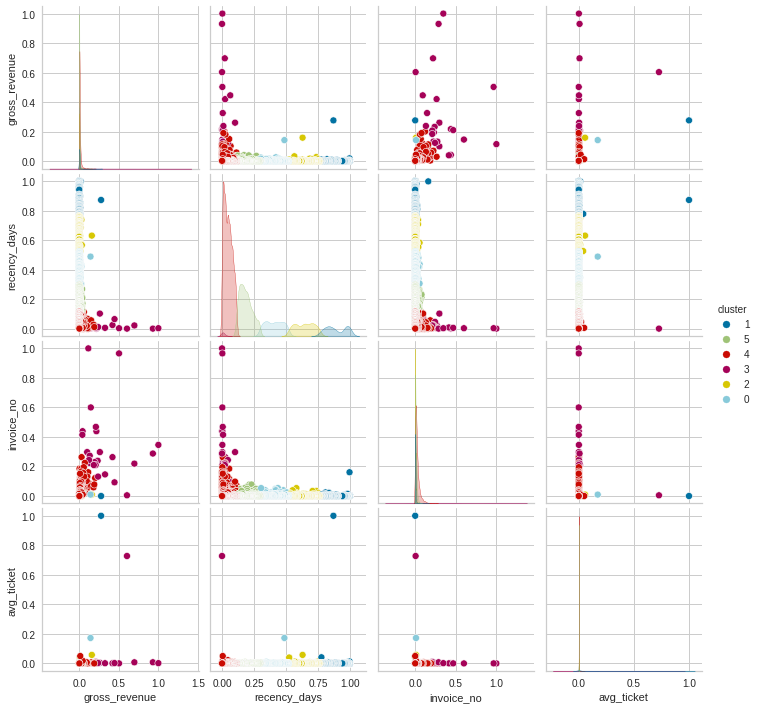

In [53]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

## 9.3. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

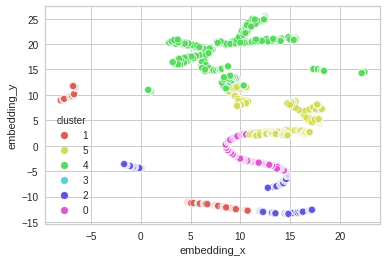

In [54]:
reducer = umap.UMAP( random_state=42, n_neighbors=40)
embedding = reducer.fit_transform(x)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())), data=df_viz)

In [55]:
# fig = px.scatter_3d(
#     df9, x='recency_days', y='invoice_no', z='gross_revenue', 
#     color='cluster', color_discrete_sequence=px.colors.qualitative.G10)

# fig.show()

## 9.2. Cluster Profile

In [56]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,0.019301,0.997319,0.160976,0.000208,1
1,13047,0.011567,0.150134,0.039024,0.000218,5
2,12583,0.024009,0.005362,0.068293,0.000347,4
3,13748,0.003384,0.254692,0.019512,0.000412,5
4,15100,0.003125,0.892761,0.009756,0.003756,1



# Cluster 1 (Candidato à Insider)

- Número de customers: 6 (0,14% dos customers)
- Recência em média: 7 dias
- Compras em média: 89 compras
- Receita em média: $182.182,00 dólares

# Cluster 2

- Número de customers: 31 (0,71% dos customers)
- Recência em média: 14 dias
- Compras em média: 53 compras
- Receita em média: $40.543,52 dólares
 
# Cluster 3

- Número de customers: 4.335 (99% dos customers)
- Recência em média: 92 dias
- Compras em média: 5 compras
- Receita em média: $1.372,53 dólares
 

In [57]:
# Number of customers
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = df_cluster['customer_id'] / df_cluster['customer_id'].sum()

# Avg Gross Revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg Recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg Inoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# avg ticket
df_avg_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,503,0.116166,0.002762,0.407144,0.005644,0.000718
1,1,318,0.073441,0.002266,0.890249,0.001641,0.003715
2,2,460,0.106236,0.002122,0.643583,0.002460,0.000657
3,3,24,0.005543,0.313026,0.014634,0.335163,0.032447
4,4,1976,0.456351,0.008521,0.045962,0.023998,0.000358
5,5,1049,0.242263,0.003720,0.185919,0.008296,0.000350


# 10.0. Deploy